### Libraries

In [1]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tempfile import TemporaryFile
import os, pickle, random, operator, math, warnings

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### ThoughtProcess:

1. Read wav files.
2. Read metadata.
3. Feature generation from wav files:
    1. **Channels**: number of channels; 1 for mono, 2 for stereo audio.
    2. **Sample width**: number of bytes per sample; 1 means 8-bit, 2 means 16-bit.
    3. **Frame rate/Sample rate**: frequency of samples used (in Hertz)
    4. **Frame width**: Number of bytes for each “frame”. One frame contains a sample for each channel.
    5. **Length**: audio file length (in milliseconds)
    6. **Frame count**: the number of frames from the sample
    7. **Intensity**: loudness in dBFS (dB relative to the maximum possible loudness)
4. Exploratory Analysis - Mostly visualisations.
5. Select features to use for classification.
6. Build a CNN or RNN.
7. Fit, evaluate, classify, evaluate.

# Data:

## Metadata:

In [3]:
path = "/home/ada/hub/MusicGenreClassification/data/fma_metadata/"
os.listdir(path)

['genres.csv',
 'not_found.pickle',
 'raw_echonest.csv',
 'raw_tracks.csv',
 'checksums',
 'track.csv',
 'raw_genres.csv',
 'tracks.csv',
 '.~lock.track.csv#',
 'raw_albums.csv',
 'echonest.csv',
 'README.txt',
 'features.csv',
 'raw_artists.csv']

### Tracks

per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks.


In [4]:
tracks = pd.read_csv(path + "tracks.csv", low_memory=False)
tracks = tracks.iloc[:, 1:]
print(tracks.shape)
tracks.head()

(106576, 52)


,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,album.9,album.10,album.11,album.12,artist,artist.1,artist.2,artist.3,artist.4,artist.5,artist.6,artist.7,artist.8,artist.9,artist.10,artist.11,artist.12,artist.13,artist.14,artist.15,artist.16,set,set.1,track,track.1,track.2,track.3,track.4,track.5,track.6,track.7,track.8,track.9,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
0,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page,split,subset,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World


In [5]:
cols = [",".join(["__".join(values) for values in zip(tracks.columns, tracks.iloc[0].values)])]
cols = [i for i in cols[0].split(",")]
new_cols = []
for col in cols:
    new_cols.append(''.join(i for i in col if not i.isdigit()))
new_cols = [new_col.replace(".", "") for new_col in new_cols]

tracks = tracks.iloc[2:]

col_rename_dict = {i:j for i,j in zip(tracks.columns, new_cols)}
tracks.rename(columns=col_rename_dict, inplace=True)

tracks.reset_index(inplace=True)
tracks.rename(columns={"index": "track__id"}, inplace=True)


tracks.head()

,track__id,album__comments,album__date_created,album__date_released,album__engineer,album__favorites,album__id,album__information,album__listens,album__producer,album__tags,album__title,album__tracks,album__type,artist__active_year_begin,artist__active_year_end,artist__associated_labels,artist__bio,artist__comments,artist__date_created,artist__favorites,artist__id,artist__latitude,artist__location,artist__longitude,artist__members,artist__name,artist__related_projects,artist__tags,artist__website,artist__wikipedia_page,set__split,set__subset,track__bit_rate,track__comments,track__composer,track__date_created,track__date_recorded,track__duration,track__favorites,track__genre_top,track__genres,track__genres_all,track__information,track__interest,track__language_code,track__license,track__listens,track__lyricist,track__number,track__publisher,track__tags,track__title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,4,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,5,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,6,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


['track__lyricist', 'track__publisher', 'track__information', 'track__composer', 'artist__active_year_end', 'artist__wikipedia_page', 'track__date_recorded', 'artist__related_projects', 'artist__associated_labels', 'track__language_code', 'album__engineer', 'album__producer', 'artist__active_year_begin', 'artist__longitude', 'artist__latitude', 'artist__members', 'track__genre_top', 'artist__location', 'album__date_released', 'artist__bio']


<AxesSubplot:xlabel='null', ylabel='cols'>

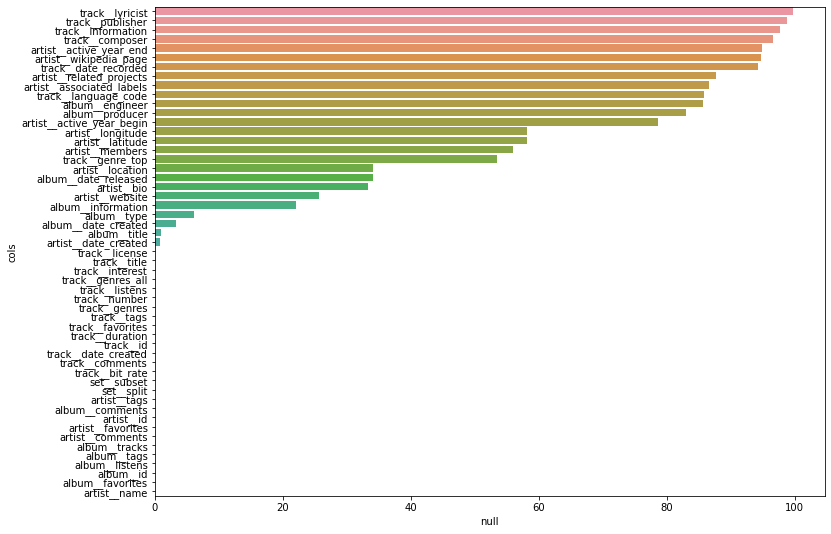

In [6]:
null = pd.DataFrame((tracks.isna().sum()/tracks.shape[0]  * 100).sort_values(ascending=False)).reset_index()
null.columns = ["cols", "null"]
# cols with >80% null
print(null.loc[null.null >= 30].cols.tolist())
plt.figure(figsize=(12,9))
sns.barplot(y=null.cols, x=null.null)

In [7]:
tracks = tracks.drop(null.loc[null.null >= 30].cols.tolist(), axis=1)
tracks.head()

,track__id,album__comments,album__date_created,album__favorites,album__id,album__information,album__listens,album__tags,album__title,album__tracks,album__type,artist__comments,artist__date_created,artist__favorites,artist__id,artist__name,artist__tags,artist__website,set__split,set__subset,track__bit_rate,track__comments,track__date_created,track__duration,track__favorites,track__genres,track__genres_all,track__interest,track__license,track__listens,track__number,track__tags,track__title
0,2,0,2008-11-26 01:44:45,4,1,<p></p>,6073,[],AWOL - A Way Of Life,7,Album,0,2008-11-26 01:42:32,9,1,AWOL,['awol'],http://www.AzillionRecords.blogspot.com,training,small,256000,0,2008-11-26 01:48:12,168,2,[21],[21],4656,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,3,[],Food
1,3,0,2008-11-26 01:44:45,4,1,<p></p>,6073,[],AWOL - A Way Of Life,7,Album,0,2008-11-26 01:42:32,9,1,AWOL,['awol'],http://www.AzillionRecords.blogspot.com,training,medium,256000,0,2008-11-26 01:48:14,237,1,[21],[21],1470,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,4,[],Electric Ave
2,4,0,2008-11-26 01:44:45,4,1,<p></p>,6073,[],AWOL - A Way Of Life,7,Album,0,2008-11-26 01:42:32,9,1,AWOL,['awol'],http://www.AzillionRecords.blogspot.com,training,small,256000,0,2008-11-26 01:48:20,206,6,[21],[21],1933,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,6,[],This World
3,5,0,2008-11-26 01:45:08,4,6,NaN,47632,[],Constant Hitmaker,2,Album,3,2008-11-26 01:42:55,74,6,Kurt Vile,"['philly', 'kurt vile']",http://kurtvile.com,training,small,192000,0,2008-11-25 17:49:06,161,178,[10],[10],54881,Attribution-NonCommercial-NoDerivatives (aka M...,50135,1,[],Freeway
4,6,0,2008-11-26 01:45:05,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,[],Niris,13,Album,2,2008-11-26 01:42:52,10,4,Nicky Cook,"['instrumentals', 'experimental pop', 'post pu...",NaN,training,large,256000,0,2008-11-26 01:48:56,311,0,"[76, 103]","[17, 10, 76, 103]",978,Attribution-NonCommercial-NoDerivatives (aka M...,361,3,[],Spiritual Level


### Genres

all 163 genres with name and parent (used to infer the genre hierarchy and top-level genres).

In [8]:
genres = pd.read_csv(path + "genres.csv", low_memory=False)
print(genres.shape)
genres.sample(10)

(163, 5)


,genre_id,#tracks,parent,title,top_level
35,45,2469,12,Loud-Rock,12
148,651,79,9,Country & Western,9
56,89,1858,25,Post-Punk,12
142,539,638,21,Rap,21
162,1235,14938,0,Instrumental,1235
48,76,7144,10,Experimental Pop,10
1,2,5271,0,International,2
120,378,177,20,Spoken Word,20
136,495,2061,15,Downtempo,15
51,81,110,92,Afrobeat,2


### features

common features extracted with librosa.

In [9]:
features = pd.read_csv(path + "features.csv", low_memory=False)
print(features.shape)
features.head(10)

(106577, 519)


,feature,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,chroma_cens.10,chroma_cens.11,chroma_cens.12,chroma_cens.13,chroma_cens.14,chroma_cens.15,chroma_cens.16,chroma_cens.17,chroma_cens.18,chroma_cens.19,chroma_cens.20,chroma_cens.21,chroma_cens.22,chroma_cens.23,chroma_cens.24,chroma_cens.25,chroma_cens.26,chroma_cens.27,chroma_cens.28,chroma_cens.29,chroma_cens.30,chroma_cens.31,chroma_cens.32,chroma_cens.33,chroma_cens.34,chroma_cens.35,chroma_cens.36,chroma_cens.37,chroma_cens.38,chroma_cens.39,chroma_cens.40,chroma_cens.41,chroma_cens.42,chroma_cens.43,chroma_cens.44,chroma_cens.45,chroma_cens.46,chroma_cens.47,chroma_cens.48,chroma_cens.49,chroma_cens.50,chroma_cens.51,chroma_cens.52,chroma_cens.53,chroma_cens.54,chroma_cens.55,chroma_cens.56,chroma_cens.57,chroma_cens.58,chroma_cens.59,chroma_cens.60,chroma_cens.61,chroma_cens.62,chroma_cens.63,chroma_cens.64,chroma_cens.65,chroma_cens.66,chroma_cens.67,chroma_cens.68,chroma_cens.69,chroma_cens.70,chroma_cens.71,chroma_cens.72,chroma_cens.73,chroma_cens.74,chroma_cens.75,chroma_cens.76,chroma_cens.77,chroma_cens.78,chroma_cens.79,chroma_cens.80,chroma_cens.81,chroma_cens.82,chroma_cens.83,chroma_cqt,chroma_cqt.1,chroma_cqt.2,chroma_cqt.3,chroma_cqt.4,chroma_cqt.5,chroma_cqt.6,chroma_cqt.7,chroma_cqt.8,chroma_cqt.9,chroma_cqt.10,chroma_cqt.11,chroma_cqt.12,chroma_cqt.13,chroma_cqt.14,chroma_cqt.15,chroma_cqt.16,chroma_cqt.17,chroma_cqt.18,chroma_cqt.19,chroma_cqt.20,chroma_cqt.21,chroma_cqt.22,chroma_cqt.23,chroma_cqt.24,chroma_cqt.25,chroma_cqt.26,chroma_cqt.27,chroma_cqt.28,chroma_cqt.29,chroma_cqt.30,chroma_cqt.31,chroma_cqt.32,chroma_cqt.33,chroma_cqt.34,chroma_cqt.35,chroma_cqt.36,chroma_cqt.37,chroma_cqt.38,chroma_cqt.39,chroma_cqt.40,chroma_cqt.41,chroma_cqt.42,chroma_cqt.43,chroma_cqt.44,chroma_cqt.45,chroma_cqt.46,chroma_cqt.47,chroma_cqt.48,chroma_cqt.49,chroma_cqt.50,chroma_cqt.51,chroma_cqt.52,chroma_cqt.53,chroma_cqt.54,chroma_cqt.55,chroma_cqt.56,chroma_cqt.57,chroma_cqt.58,chroma_cqt.59,chroma_cqt.60,chroma_cqt.61,chroma_cqt.62,chroma_cqt.63,chroma_cqt.64,chroma_cqt.65,chroma_cqt.66,chroma_cqt.67,chroma_cqt.68,chroma_cqt.69,chroma_cqt.70,chroma_cqt.71,chroma_cqt.72,chroma_cqt.73,chroma_cqt.74,chroma_cqt.75,chroma_cqt.76,chroma_cqt.77,chroma_cqt.78,chroma_cqt.79,chroma_cqt.80,chroma_cqt.81,chroma_cqt.82,chroma_cqt.83,chroma_stft,chroma_stft.1,chroma_stft.2,chroma_stft.3,chroma_stft.4,chroma_stft.5,chroma_stft.6,chroma_stft.7,chroma_stft.8,chroma_stft.9,chroma_stft.10,chroma_stft.11,chroma_stft.12,chroma_stft.13,chroma_stft.14,chroma_stft.15,chroma_stft.16,chroma_stft.17,chroma_stft.18,chroma_stft.19,chroma_stft.20,chroma_stft.21,chroma_stft.22,chroma_stft.23,chroma_stft.24,chroma_stft.25,chroma_stft.26,chroma_stft.27,chroma_stft.28,chroma_stft.29,chroma_stft.30,chroma_stft.31,chroma_stft.32,chroma_stft.33,chroma_stft.34,chroma_stft.35,chroma_stft.36,chroma_stft.37,chroma_stft.38,chroma_stft.39,chroma_stft.40,chroma_stft.41,chroma_stft.42,chroma_stft.43,chroma_stft.44,chroma_stft.45,chroma_stft.46,chroma_stft.47,chroma_stft.48,chroma_stft.49,chroma_stft.50,chroma_stft.51,chroma_stft.52,chroma_stft.53,chroma_stft.54,chroma_stft.55,chroma_stft.56,chroma_stft.57,chroma_stft.58,chroma_stft.59,chroma_stft.60,chroma_stft.61,chroma_stft.62,chroma_stft.63,chroma_stft.64,chroma_stft.65,chroma_stft.66,chroma_stft.67,chroma_stft.68,chroma_stft.69,chroma_stft.70,chroma_stft.71,chroma_stft.72,chroma_stft.73,chroma_stft.74,chroma_stft.75,chroma_stft.76,chroma_stft.77,chroma_stft.78,chroma_stft.79,chroma_stft.80,chroma_stft.81,chroma_stft.82,chroma_stft.83,mfcc,mfcc.1,mfcc.2,mfcc.3,mfcc.4,mfcc.5,mfcc.6,mfcc.7,mfcc.8,mfcc.9,mfcc.10,mfcc.11,mfcc.12,mfcc.13,mfcc.14,mfcc.15,mfcc.16,mfcc.17,mfcc.18,mfcc.19,mfcc.20,mfcc.21,mfcc.22,mfcc.23,mfcc.24,mfcc.25,mfcc.26,mfcc.27,mfcc.28,mfcc.29,mfcc.30,mfcc.31,mfcc.32,mfcc.33,mfcc.34,mfcc.35,mfcc.36,mfcc.37,mfcc.38,mfcc.39,mfcc.40,mfcc.41,mfcc.42

In [10]:
cols = [",".join(["__".join(values) for values in zip(features.columns, features.iloc[0].values)])]
cols = [i for i in cols[0].split(",")]

features = features.iloc[3:]

col_rename_dict = {i:j for i,j in zip(features.columns, cols)}
features.rename(columns=col_rename_dict, inplace=True)
features.rename(columns={"feature__statistics": "track__id"}, inplace=True)


features.head()

,track__id,chroma_cens__kurtosis,chroma_cens.1__kurtosis,chroma_cens.2__kurtosis,chroma_cens.3__kurtosis,chroma_cens.4__kurtosis,chroma_cens.5__kurtosis,chroma_cens.6__kurtosis,chroma_cens.7__kurtosis,chroma_cens.8__kurtosis,chroma_cens.9__kurtosis,chroma_cens.10__kurtosis,chroma_cens.11__kurtosis,chroma_cens.12__max,chroma_cens.13__max,chroma_cens.14__max,chroma_cens.15__max,chroma_cens.16__max,chroma_cens.17__max,chroma_cens.18__max,chroma_cens.19__max,chroma_cens.20__max,chroma_cens.21__max,chroma_cens.22__max,chroma_cens.23__max,chroma_cens.24__mean,chroma_cens.25__mean,chroma_cens.26__mean,chroma_cens.27__mean,chroma_cens.28__mean,chroma_cens.29__mean,chroma_cens.30__mean,chroma_cens.31__mean,chroma_cens.32__mean,chroma_cens.33__mean,chroma_cens.34__mean,chroma_cens.35__mean,chroma_cens.36__median,chroma_cens.37__median,chroma_cens.38__median,chroma_cens.39__median,chroma_cens.40__median,chroma_cens.41__median,chroma_cens.42__median,chroma_cens.43__median,chroma_cens.44__median,chroma_cens.45__median,chroma_cens.46__median,chroma_cens.47__median,chroma_cens.48__min,chroma_cens.49__min,chroma_cens.50__min,chroma_cens.51__min,chroma_cens.52__min,chroma_cens.53__min,chroma_cens.54__min,chroma_cens.55__min,chroma_cens.56__min,chroma_cens.57__min,chroma_cens.58__min,chroma_cens.59__min,chroma_cens.60__skew,chroma_cens.61__skew,chroma_cens.62__skew,chroma_cens.63__skew,chroma_cens.64__skew,chroma_cens.65__skew,chroma_cens.66__skew,chroma_cens.67__skew,chroma_cens.68__skew,chroma_cens.69__skew,chroma_cens.70__skew,chroma_cens.71__skew,chroma_cens.72__std,chroma_cens.73__std,chroma_cens.74__std,chroma_cens.75__std,chroma_cens.76__std,chroma_cens.77__std,chroma_cens.78__std,chroma_cens.79__std,chroma_cens.80__std,chroma_cens.81__std,chroma_cens.82__std,chroma_cens.83__std,chroma_cqt__kurtosis,chroma_cqt.1__kurtosis,chroma_cqt.2__kurtosis,chroma_cqt.3__kurtosis,chroma_cqt.4__kurtosis,chroma_cqt.5__kurtosis,chroma_cqt.6__kurtosis,chroma_cqt.7__kurtosis,chroma_cqt.8__kurtosis,chroma_cqt.9__kurtosis,chroma_cqt.10__kurtosis,chroma_cqt.11__kurtosis,chroma_cqt.12__max,chroma_cqt.13__max,chroma_cqt.14__max,chroma_cqt.15__max,chroma_cqt.16__max,chroma_cqt.17__max,chroma_cqt.18__max,chroma_cqt.19__max,chroma_cqt.20__max,chroma_cqt.21__max,chroma_cqt.22__max,chroma_cqt.23__max,chroma_cqt.24__mean,chroma_cqt.25__mean,chroma_cqt.26__mean,chroma_cqt.27__mean,chroma_cqt.28__mean,chroma_cqt.29__mean,chroma_cqt.30__mean,chroma_cqt.31__mean,chroma_cqt.32__mean,chroma_cqt.33__mean,chroma_cqt.34__mean,chroma_cqt.35__mean,chroma_cqt.36__median,chroma_cqt.37__median,chroma_cqt.38__median,chroma_cqt.39__median,chroma_cqt.40__median,chroma_cqt.41__median,chroma_cqt.42__median,chroma_cqt.43__median,chroma_cqt.44__median,chroma_cqt.45__median,chroma_cqt.46__median,chroma_cqt.47__median,chroma_cqt.48__min,chroma_cqt.49__min,chroma_cqt.50__min,chroma_cqt.51__min,chroma_cqt.52__min,chroma_cqt.53__min,chroma_cqt.54__min,chroma_cqt.55__min,chroma_cqt.56__min,chroma_cqt.57__min,chroma_cqt.58__min,chroma_cqt.59__min,chroma_cqt.60__skew,chroma_cqt.61__skew,chroma_cqt.62__skew,chroma_cqt.63__skew,chroma_cqt.64__skew,chroma_cqt.65__skew,chroma_cqt.66__skew,chroma_cqt.67__skew,chroma_cqt.68__skew,chroma_cqt.69__skew,chroma_cqt.70__skew,chroma_cqt.71__skew,chroma_cqt.72__std,chroma_cqt.73__std,chroma_cqt.74__std,chroma_cqt.75__std,chroma_cqt.76__std,chroma_cqt.77__std,chroma_cqt.78__std,chroma_cqt.79__std,chroma_cqt.80__std,chroma_cqt.81__std,chroma_cqt.82__std,chroma_cqt.83__std,chroma_stft__kurtosis,chroma_stft.1__kurtosis,chroma_stft.2__kurtosis,chroma_stft.3__kurtosis,chroma_stft.4__kurtosis,chroma_stft.5__kurtosis,chroma_stft.6__kurtosis,chroma_stft.7__kurtosis,chroma_stft.8__kurtosis,chroma_stft.9__kurtosis,chroma_stft.10__kurtosis,chroma_stft.11__kurtosis,chroma_stft.12__max,chroma_stft.13__max,chroma_stft.14__max,chroma_stft.15__max,chroma_stft.16__max,chroma_stft.17__max,chroma_stft.18__max,chroma_stft.19__max,chroma_stft.20__max,chroma_stft.21__max,chroma_st

### echonest

audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks.

In [11]:
echo = pd.read_csv(path + "echonest.csv", low_memory=False, header=2)
print(echo.shape)
echo.head()

(13130, 250)


,Unnamed: 0,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss,000,001,002,003,004,005,006,007,008,009,010,011,012,013,014,015,016,017,018,019,020,021,022,023,024,025,026,027,028,029,030,031,032,033,034,035,036,037,038,039,040,041,042,043,044,045,046,047,048,049,050,051,052,053,054,055,056,057,058,059,060,061,062,063,064,065,066,067,068,069,070,071,072,073,074,075,076,077,078,079,080,081,082,083,084,085,086,087,088,089,090,091,092,093,094,095,096,097,098,099,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223
0,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life,NaN,NaN,NaN,NaN,NaN,0.388990,0.386740,0.406370,0.000000,0.000000,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,0.318376,0.371974,1.000,0.5710,0.278,0.2100,0.2150,0.2285,0.2375,0.279,0.1685,0.1685,0.279,0.3325,0.049848,0.104212,0.060230,0.052290,0.047403,0.052815,0.052733,0.062216,0.051613,0.057399,0.053199,0.062583,0.036,0.018,0.017,0.021,0.021,0.010,0.015,0.041,0.010,0.009,0.021,0.013,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.964,0.982,0.983,0.979,0.979,0.990,0.985,0.959,0.990,0.991,0.979,0.987,-1.899342,-0.032654,0.878469,1.147538,0.950856,0.948257,1.157887,1.147911,1.646318,1.530193,1.197568,0.745673,2.510038,-1.500183,0.030540,0.694242,0.170432,0.064695,0.874727,0.722576,2.251320,1.708159,1.054857,0.020675,42.949131,44.387436,32.409389,15.668667,10.114028,-4.069252,2.042353,2.188321,-3.805923,-0.494699,6.024670,10.692599,44.442501,42.3885,31.684999,9.987500,9.568501,-7.1485,3.8315,1.8505,-2.6875,-0.800,5.4615,10.2565,39.494820,1966.979126,1825.123047,1903.756714,828.810059,911.155823,581.015320,722.001404,404.682556,315.528473,376.632416,229.282547,0.0,-110.367996,-100.605003,-112.581001,-75.882004,-89.160004,-80.737999,-91.498001,-66.649002,-61.845001,-66.081001,-58.043999,52.006001,216.237000,208.423004,145.194000,97.482002,98.723000,68.091003,101.588997,69.505997,58.227001,69.262001,58.175999,52.006001,326.604980,309.028015,257.774994,173.364014,187.882996,148.829010,193.087006,136.154999,120.072006,135.343002,116.220001,-2.952152,0.060379,0.525976,0.365915,0.018182,0.454431,-0.330007,0.14939

In [12]:
echo = echo.loc[1:]
echo.rename(columns = {"Unnamed: 0": "track__id"}, inplace=True)
echo.head()

,track__id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss,000,001,002,003,004,005,006,007,008,009,010,011,012,013,014,015,016,017,018,019,020,021,022,023,024,025,026,027,028,029,030,031,032,033,034,035,036,037,038,039,040,041,042,043,044,045,046,047,048,049,050,051,052,053,054,055,056,057,058,059,060,061,062,063,064,065,066,067,068,069,070,071,072,073,074,075,076,077,078,079,080,081,082,083,084,085,086,087,088,089,090,091,092,093,094,095,096,097,098,099,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223
1,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life,NaN,NaN,NaN,NaN,NaN,0.388990,0.386740,0.406370,0.000000,0.000000,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,0.318376,0.371974,1.000,0.5710,0.278,0.2100,0.2150,0.2285,0.2375,0.279,0.1685,0.1685,0.279,0.3325,0.049848,0.104212,0.060230,0.052290,0.047403,0.052815,0.052733,0.062216,0.051613,0.057399,0.053199,0.062583,0.036,0.018,0.017,0.021,0.021,0.010,0.015,0.041,0.010,0.009,0.021,0.013,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.964,0.982,0.983,0.979,0.979,0.990,0.985,0.959,0.990,0.991,0.979,0.987,-1.899342,-0.032654,0.878469,1.147538,0.950856,0.948257,1.157887,1.147911,1.646318,1.530193,1.197568,0.745673,2.510038,-1.500183,0.030540,0.694242,0.170432,0.064695,0.874727,0.722576,2.251320,1.708159,1.054857,0.020675,42.949131,44.387436,32.409389,15.668667,10.114028,-4.069252,2.042353,2.188321,-3.805923,-0.494699,6.024670,10.692599,44.442501,42.388500,31.684999,9.987500,9.568501,-7.1485,3.8315,1.8505,-2.6875,-0.800,5.4615,10.2565,39.494820,1966.979126,1825.123047,1903.756714,828.810059,911.155823,581.015320,722.001404,404.682556,315.528473,376.632416,229.282547,0.000,-110.367996,-100.605003,-112.581001,-75.882004,-89.160004,-80.737999,-91.498001,-66.649002,-61.845001,-66.081001,-58.043999,52.006001,216.237000,208.423004,145.194000,97.482002,98.723000,68.091003,101.588997,69.505997,58.227001,69.262001,58.175999,52.006001,326.604980,309.028015,257.774994,173.364014,187.882996,148.829010,193.087006,136.154999,120.072006,135.343002,116.220001,-2.952152,0.060379,0.525976,0.365915,0.018182,0.454431,-0.330007,0.149395,-0.214859,0.030427,-0.153877,-0.150132,13.206213,1.009934,1.577194,0.337023,0.097149,0.401260,0.006324,0.643486,0.012059,0.237947,0.655938,1.213864,-12.486146,-11.2695,46.031261,-60.000000,-3.933,56.067001,-2.587475,11.802585,0.047970,0.038275,0.000988,0.00000,0.20730,0.20730,1.603659,2.984276,-21.812077,-20.312000,49.157482,-60.0,-9.691,50.308998,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
2,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life,NaN,NaN,NaN,NaN,NaN,0.388990,0.386740,0.406370,0.000000,0.000000,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,0.474559,0.406729,0.506,0.5145,0.387,0.3235,0.2805,0.3135,0.3455,0.898,0.4365,0.3385,0.398,0.3480,0.079207,0.083319,0.073595,0.071024,0.056679,0.066113,0.073889,0.088100,0.071305,0.059275,0.088222,0.067298,0.040,0.040,0.029,0.021,0.009,0.020,0.020,0.053,0.022,0.032,

### Tracks, Features and Echonest

In [13]:
tracks.track__id.nunique(), features.track__id.nunique(), echo.track__id.nunique()

(106574, 106574, 13129)

In [14]:
tracks.track__id = tracks.track__id.astype(int)
features.track__id = features.track__id.astype(int)
echo.track__id = echo.track__id.astype(int)

In [15]:
meta = tracks.merge(features, how="left", on = "track__id")
print(tracks.shape, features.shape, meta.shape)

(106574, 33) (106574, 519) (106574, 551)


In [16]:
meta = meta.merge(echo, how="left", on = "track__id")
print(echo.shape, meta.shape)
meta.sample(5)

(13129, 250) (106574, 800)


,track__id,album__comments,album__date_created,album__favorites,album__id,album__information,album__listens,album__tags,album__title,album__tracks,album__type,artist__comments,artist__date_created,artist__favorites,artist__id,artist__name,artist__tags,artist__website,set__split,set__subset,track__bit_rate,track__comments,track__date_created,track__duration,track__favorites,track__genres,track__genres_all,track__interest,track__license,track__listens,track__number,track__tags,track__title,chroma_cens__kurtosis,chroma_cens.1__kurtosis,chroma_cens.2__kurtosis,chroma_cens.3__kurtosis,chroma_cens.4__kurtosis,chroma_cens.5__kurtosis,chroma_cens.6__kurtosis,chroma_cens.7__kurtosis,chroma_cens.8__kurtosis,chroma_cens.9__kurtosis,chroma_cens.10__kurtosis,chroma_cens.11__kurtosis,chroma_cens.12__max,chroma_cens.13__max,chroma_cens.14__max,chroma_cens.15__max,chroma_cens.16__max,chroma_cens.17__max,chroma_cens.18__max,chroma_cens.19__max,chroma_cens.20__max,chroma_cens.21__max,chroma_cens.22__max,chroma_cens.23__max,chroma_cens.24__mean,chroma_cens.25__mean,chroma_cens.26__mean,chroma_cens.27__mean,chroma_cens.28__mean,chroma_cens.29__mean,chroma_cens.30__mean,chroma_cens.31__mean,chroma_cens.32__mean,chroma_cens.33__mean,chroma_cens.34__mean,chroma_cens.35__mean,chroma_cens.36__median,chroma_cens.37__median,chroma_cens.38__median,chroma_cens.39__median,chroma_cens.40__median,chroma_cens.41__median,chroma_cens.42__median,chroma_cens.43__median,chroma_cens.44__median,chroma_cens.45__median,chroma_cens.46__median,chroma_cens.47__median,chroma_cens.48__min,chroma_cens.49__min,chroma_cens.50__min,chroma_cens.51__min,chroma_cens.52__min,chroma_cens.53__min,chroma_cens.54__min,chroma_cens.55__min,chroma_cens.56__min,chroma_cens.57__min,chroma_cens.58__min,chroma_cens.59__min,chroma_cens.60__skew,chroma_cens.61__skew,chroma_cens.62__skew,chroma_cens.63__skew,chroma_cens.64__skew,chroma_cens.65__skew,chroma_cens.66__skew,chroma_cens.67__skew,chroma_cens.68__skew,chroma_cens.69__skew,chroma_cens.70__skew,chroma_cens.71__skew,chroma_cens.72__std,chroma_cens.73__std,chroma_cens.74__std,chroma_cens.75__std,chroma_cens.76__std,chroma_cens.77__std,chroma_cens.78__std,chroma_cens.79__std,chroma_cens.80__std,chroma_cens.81__std,chroma_cens.82__std,chroma_cens.83__std,chroma_cqt__kurtosis,chroma_cqt.1__kurtosis,chroma_cqt.2__kurtosis,chroma_cqt.3__kurtosis,chroma_cqt.4__kurtosis,chroma_cqt.5__kurtosis,chroma_cqt.6__kurtosis,chroma_cqt.7__kurtosis,chroma_cqt.8__kurtosis,chroma_cqt.9__kurtosis,chroma_cqt.10__kurtosis,chroma_cqt.11__kurtosis,chroma_cqt.12__max,chroma_cqt.13__max,chroma_cqt.14__max,chroma_cqt.15__max,chroma_cqt.16__max,chroma_cqt.17__max,chroma_cqt.18__max,chroma_cqt.19__max,chroma_cqt.20__max,chroma_cqt.21__max,chroma_cqt.22__max,chroma_cqt.23__max,chroma_cqt.24__mean,chroma_cqt.25__mean,chroma_cqt.26__mean,chroma_cqt.27__mean,chroma_cqt.28__mean,chroma_cqt.29__mean,chroma_cqt.30__mean,chroma_cqt.31__mean,chroma_cqt.32__mean,chroma_cqt.33__mean,chroma_cqt.34__mean,chroma_cqt.35__mean,chroma_cqt.36__median,chroma_cqt.37__median,chroma_cqt.38__median,chroma_cqt.39__median,chroma_cqt.40__median,chroma_cqt.41__median,chroma_cqt.42__median,chroma_cqt.43__median,chroma_cqt.44__median,chroma_cqt.45__median,chroma_cqt.46__median,chroma_cqt.47__median,chroma_cqt.48__min,chroma_cqt.49__min,chroma_cqt.50__min,chroma_cqt.51__min,chroma_cqt.52__min,chroma_cqt.53__min,chroma_cqt.54__min,chroma_cqt.55__min,chroma_cqt.56__min,chroma_cqt.57__min,chroma_cqt.58__min,chroma_cqt.59__min,chroma_cqt.60__skew,chroma_cqt.61__skew,chroma_cqt.62__skew,chroma_cqt.63__skew,chroma_cqt.64__skew,chroma_cqt.65__skew,chroma_cqt.66__skew,chroma_cqt.67__skew,chroma_cqt.68__skew,chroma_cqt.69__skew,chroma_cqt.70__skew,chroma_cqt.71__skew,chroma_cqt.72__std,chroma_cqt.73__std,chroma_cqt.74__std,chroma_cqt.75__std,chroma_cqt.76__std,chroma_cqt.77__std,chroma_cqt.78__std,chroma_cqt.79__std,chroma_cqt.80__std,chroma_cqt.81__std,chroma_cqt.82__std,chroma_cqt.83__std,chroma_stft__ku

### Clean Up: Null Values

In [22]:
null = pd.DataFrame((meta.isna().sum()/meta.shape[0]  * 100).sort_values(ascending=False)).reset_index()
null.columns = ["cols", "null"]

# cols with >80% null
meta.drop(null.loc[null.null >= 80].cols.tolist(), axis=1, inplace=True)

<AxesSubplot:xlabel='null', ylabel='cols'>

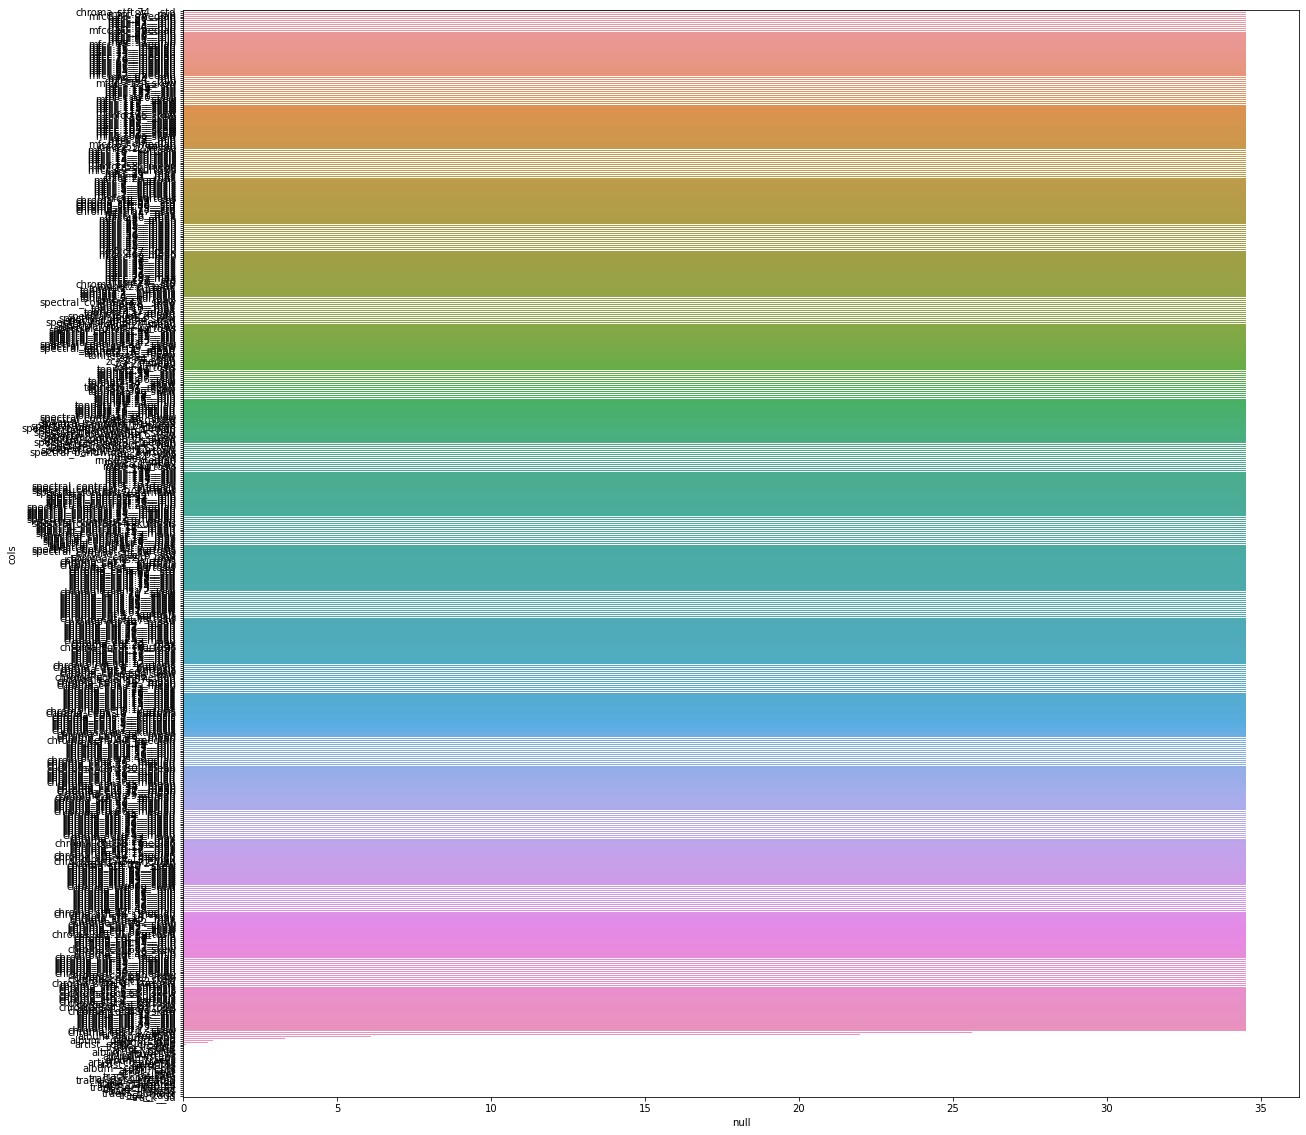

In [23]:
null = pd.DataFrame((meta.isna().sum()/meta.shape[0]  * 100).sort_values(ascending=False)).reset_index()
null.columns = ["cols", "null"]

plt.figure(figsize=(20, 20))
sns.barplot(y=null.cols, x=null.null)

ignore the invisible labels but observe how they all have same %.

In [30]:
(34.522491 * meta.shape[0])/100, meta.shape[0] - ((34.522491 * meta.shape[0])/100), meta.shape, null.shape

(36791.99955834, 69782.00044166, (106574, 551), (551, 2))

100k to 70k; not as bad as losing 551 cols.

In [ ]:
meta = meta.dropna(subset = ["chroma_stft.74__std"])

null = pd.DataFrame((meta.isna().sum()/meta.shape[0]  * 100).sort_values(ascending=False)).reset_index()
null.columns = ["cols", "null"]

In [40]:
null.cols.loc[null['null'] > 0].tolist()

['artist__website',
 'album__information',
 'album__type',
 'album__date_created',
 'album__title',
 'artist__date_created',
 'track__license',
 'track__title']

In [43]:
meta.drop(['artist__website', 'album__information', 'album__type', 
           'album__date_created', 'album__title', 'artist__date_created', 'track__license', 'track__title'], axis=1, inplace=True)
meta.shape

(69782, 543)

## Metadata: Exploratory Analysis

In [ ]:
meta.sample(5)